In [1]:
import os

In [2]:
from muscima.io import parse_cropobject_list

In [3]:
CROPOBJECT_DIR = os.path.join(os.environ['HOME'], 'Documents/Ecole Polytechnique/3A/ComputerVision/Project/v1.0/data/cropobjects_manual')

In [4]:
cropobject_fnames = [os.path.join(CROPOBJECT_DIR, f) for f in os.listdir(CROPOBJECT_DIR)]
docs = [parse_cropobject_list(f) for f in cropobject_fnames]

## Symbol Classification

# Tell apart quarter notes from half notes

# Extracting notes

In [5]:
len(docs)

140

In [6]:
cropobjects = docs[0]

In [7]:
cropobjects[0]

In [8]:
_cropobj_dict = {c.objid: c for c in cropobjects}


In [9]:
from pdb import set_trace

In [10]:
notes = []

In [11]:
# Bear in mind that the outlinks are integers, only valid within the same document.
# Therefore, we define a function per-document, not per-dataset.

def extract_notes_from_doc(cropobjects):
    """Finds all ``(full-notehead, stem)`` pairs that form
    quarter or half notes. Returns two lists of CropObject tuples:
    one for quarter notes, one of half notes.

    :returns: quarter_notes, half_notes
    """
    _cropobj_dict = {c.objid: c for c in cropobjects}

    notes = []
    for c in cropobjects:
        if (c.clsname == 'notehead-full') or (c.clsname == 'notehead-empty'):
            _has_stem = False
            _has_beam_or_flag = False
            stem_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                if _o_obj.clsname == 'stem':
                    _has_stem = True
                    stem_obj = _o_obj
                elif _o_obj.clsname == 'beam':
                    _has_beam_or_flag = True
                elif _o_obj.clsname.endswith('flag'):
                    _has_beam_or_flag = True
            if _has_stem and (not _has_beam_or_flag):
                # We also need to check against quarter-note chords.
                # Stems only have inlinks from noteheads, so checking
                # for multiple inlinks will do the trick.
                if len(stem_obj.inlinks) == 1:
                    notes.append((c, stem_obj))

    quarter_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-full']
    half_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-empty']
    return quarter_notes, half_notes

In [12]:
qns_and_hns = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

In [13]:
import itertools

In [14]:
qns = list(itertools.chain(*[qn for qn,hn in qns_and_hns]))
hns = list(itertools.chain(*[hn for qn,hn in qns_and_hns]))
len(qns), len(hns)

(4290, 1199)

In [15]:
print(qns[0][1])

<CropObject xml:id="MUSCIMA-pp_1.0___CVC-MUSCIMA_W-44_N-13_D-ideal___115">
	<Id>115</Id>
	<ClassName>stem</ClassName>
	<Top>273</Top>
	<Left>362</Left>
	<Width>12</Width>
	<Height>58</Height>
	<Mask>0:8 1:3 0:9 1:3 0:9 1:3 0:9 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:7 1:4 0:8 1:4 0:9 1:4 0:8 1:4 0:8 1:4 0:8 1:3 0:9 1:3 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:7 1:5 0:7 1:5 0:7 1:5 0:7 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:7 1:5 0:7 1:5 0:7 1:5 0:7 1:4 0:8 1:4 0:7 1:5 0:7 1:5 0:7 1:4 0:8 1:4 0:8 1:4 0:8 1:4 0:8 1:5 0:7 1:5 0:7 1:5 0:3 1:1 0:3 1:5 0:3 1:9 0:4 1:8 0:5 1:2 0:2 1:2 0:7 1:1 0:8</Mask>
	<Inlinks>0</Inlinks>
</CropObject>


In [16]:
import numpy

def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""

    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])

    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = numpy.zeros((height, width), dtype='uint8')

    for c in cropobjects:
        # Get coordinates of upper left corner of the CropObject
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask

    canvas[canvas > 0] = 1
    return canvas

qn_images = [get_image(qn) for qn in qns]
hn_images = [get_image(hn) for hn in hns]

In [17]:
qn_images

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(73, 25), dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(66, 25), dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(94, 26), dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(92, 22), dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],

In [18]:
import matplotlib.pyplot as plt

def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

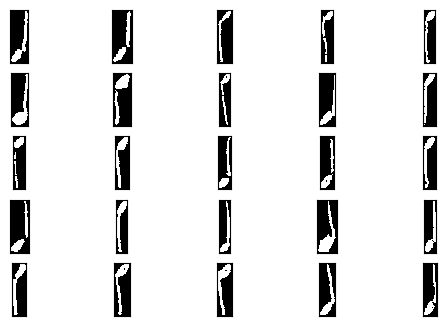

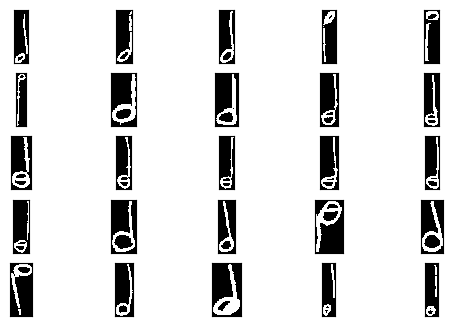

In [19]:
show_masks(qn_images[:25])
show_masks(hn_images[:25])

# Feature Extraction


In [20]:
from skimage.transform import resize

In [21]:
qn_resized = [resize(qn,(40,10)) for qn in qn_images]
hn_resized = [resize(hn, (40,10)) for hn in hn_images]


In [22]:
for qn in qn_resized:
    qn[qn>0] = 1
for hn in hn_resized:
    hn[hn>0] = 1


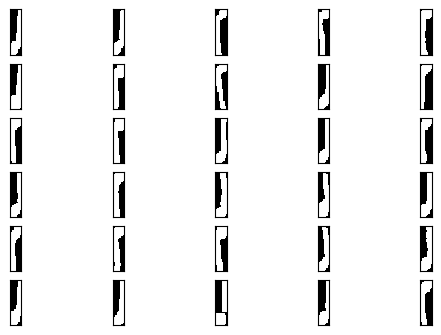

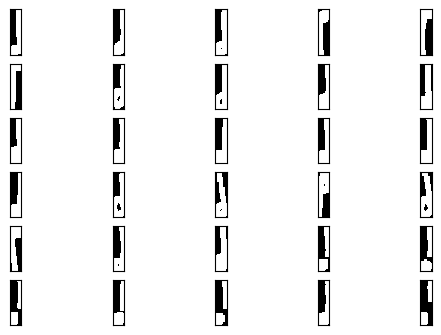

In [23]:
show_masks(qn_resized[:30])
show_masks(hn_resized[:30])

In [24]:
# Randomly pick an eqaul number of quarter-notes

n_hn = len(hn_resized)
import random
random.shuffle(qn_resized)
qn_selected = qn_resized[:n_hn]

In [25]:
Q_LABEL = 1
H_LABEL = 0


In [28]:
qn_labels = [Q_LABEL for _ in qn_selected]
hn_labels = [H_LABEL for _ in hn_resized]
notes = qn_selected + hn_resized

In [29]:
# Flatten data
notes_flattened = [n.flatten() for n in notes]
labels = qn_labels + hn_labels

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    notes_flattened, labels, test_size=0.25, random_state=42,
    stratify=labels)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

K=5

# Trying the defaults first.
clf = KNeighborsClassifier(n_neighbors=K)
clf.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [32]:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,1


In [33]:
y_test_pred = clf.predict(X_test)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=['half', 'quarter']))

              precision    recall  f1-score   support

        half       0.81      0.86      0.84       300
     quarter       0.85      0.80      0.83       300

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

